In [1]:
# installations
!pip install TextBlob
!pip install nltk
!pip install tensorflow
!pip install transformers
!pip install tf-keras

from spacy.cli import download
print(download('en_core_web_sm'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 2.7 MB/s eta 0:00:00 MB/s eta 0:00:01:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
None


In [31]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
import json
import os
import spacy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score
from transformers import BertTokenizer, BertModel
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.multioutput import MultiOutputClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [3]:
# getting data ready
p_fake_data_raw = pd.read_csv("../dataset/politifact_fake.csv")
p_real_data_raw = pd.read_csv("../dataset/politifact_real.csv")

In [4]:
# preprocessing-1 (input --> raw dataframe. output --> ['id', 'news_url', 'title', 'tweet_ids', 'text', 'images']
import os
import json
import pandas as pd

def process_dataset(base_path, data_frame):
    """
    Process a dataset by adding JSON data from folder paths.

    Parameters:
        base_path (str): The base folder path for the dataset (real or fake).
        data_frame (pd.DataFrame): The DataFrame containing the dataset.

    Returns:
        pd.DataFrame: The updated DataFrame with additional data from JSON files.
    """
    new_data = []

    for index, row in data_frame.iterrows():
        folder_path = os.path.join(base_path, str(row['id']))
        json_file_path = os.path.join(folder_path, 'new_file.json')  # JSON file is named 'new_file.json'
        
        # Check if the file exists
        if os.path.exists(json_file_path):
            # Load the JSON file
            with open(json_file_path, 'r') as file:
                data = json.load(file)
            
            # Extract relevant data from the JSON file (e.g., 'url', 'text', 'images')
            json_data = {
                'text': data.get('text'),
                'images': data.get('images'),
            }
            
            # Add this data to the current row in the DataFrame
            updated_row = row.to_dict()  # Convert the row to a dictionary
            updated_row.update(json_data)  # Add the JSON data to this dictionary
            
            # Append the updated row to the new_data list
            new_data.append(updated_row)
        else:
            print(f"File not found for id {row['id']} at path {json_file_path}")

    # Convert the new data back into a DataFrame
    updated_df = pd.DataFrame(new_data)
    return updated_df

# Base paths for fake and real datasets
base_fake_path = '../fakenewsnet/FakeNewsNet/code/fakenewsnet_dataset/politifact/fake/'
base_real_path = '../fakenewsnet/FakeNewsNet/code/fakenewsnet_dataset/politifact/real/'

# Assuming `p_fake_data_raw_sorted` and `p_real_data_raw_sorted` are the original DataFrames
p_fake_data_raw = process_dataset(base_fake_path, p_fake_data_raw)
p_real_data_raw = process_dataset(base_real_path, p_real_data_raw)

# Print results for verification
print("Fake dataset:")
print(p_fake_data_raw.head())

print("\nReal dataset:")
print(p_real_data_raw.head())


File not found for id politifact15014 at path ../fakenewsnet/FakeNewsNet/code/fakenewsnet_dataset/politifact/fake/politifact15014/new_file.json
File not found for id politifact14233 at path ../fakenewsnet/FakeNewsNet/code/fakenewsnet_dataset/politifact/fake/politifact14233/new_file.json
File not found for id politifact14890 at path ../fakenewsnet/FakeNewsNet/code/fakenewsnet_dataset/politifact/fake/politifact14890/new_file.json
File not found for id politifact14755 at path ../fakenewsnet/FakeNewsNet/code/fakenewsnet_dataset/politifact/fake/politifact14755/new_file.json
File not found for id politifact14258 at path ../fakenewsnet/FakeNewsNet/code/fakenewsnet_dataset/politifact/fake/politifact14258/new_file.json
File not found for id politifact13949 at path ../fakenewsnet/FakeNewsNet/code/fakenewsnet_dataset/politifact/fake/politifact13949/new_file.json
File not found for id politifact14700 at path ../fakenewsnet/FakeNewsNet/code/fakenewsnet_dataset/politifact/fake/politifact14700/new_fi

In [5]:
# preprocessing-2 (input --> ['id', 'news_url', 'title', 'tweet_ids', 'text', 'images'], output --> ['id', 'news_url', 'title', 'tweet_ids', 'text', 'images','cleaned_text']

def preprocess_text(text):
    # Remove HTML tags using BeautifulSoup
    text = BeautifulSoup(text, "html.parser").get_text()
    
    # Remove special characters and numbers, and convert to lowercase
    text = re.sub(r'[^A-Za-z\s]', '', text.lower())
    
    # Tokenize text
    words = text.split()
    
    # Remove stop words
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    return ' '.join(words)

p_fake_data_raw['cleaned_text'] =p_fake_data_raw['text'].apply(preprocess_text) 
p_real_data_raw['cleaned_text'] =p_real_data_raw['text'].apply(preprocess_text) 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kaushik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kaushik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kaushik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kaushik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kaushik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kaushik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kaushik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!

In [6]:
# preprocessing-3 

nlp = spacy.load('en_core_web_sm')

# Function to extract named entities and categorize them
def extract_entities(text):
    doc = nlp(text)
    entities = {'PERSON': [], 'ORG': [], 'GPE': []}  # Store lists of entities instead of counts
    
    for ent in doc.ents:
        if ent.label_ in entities:
            entities[ent.label_].append(ent.text)  # Append the entity to the appropriate list
            
    return entities

# Apply NER extraction to the dataset
p_fake_data_raw['entities'] = p_fake_data_raw['cleaned_text'].apply(extract_entities)
p_real_data_raw['entities'] = p_real_data_raw['cleaned_text'].apply(extract_entities)

# Expand the entities into separate columns
df_entities = pd.json_normalize(p_fake_data_raw['entities'])  # Now, each column will store a list of entities
p_fake_data_raw_ner = pd.concat([p_fake_data_raw, df_entities], axis=1)

df_entities = pd.json_normalize(p_real_data_raw['entities'])  # Now, each column will store a list of entities
p_real_data_raw_ner = pd.concat([p_real_data_raw, df_entities], axis=1)

# Output the result
print(p_fake_data_raw_ner[['cleaned_text', 'PERSON', 'ORG', 'GPE']])  # Example output with the named entity columns
print(p_real_data_raw_ner[['cleaned_text', 'PERSON', 'ORG', 'GPE']])  # Example output with the named entity columns

                                          cleaned_text  \
0    west texas federal appeals court operating rd ...   
1                                                        
2    share twitter share facebook share google shar...   
3    president trump administration voted united na...   
4    aderito report report change comment remove co...   
..                                                 ...   
379  thousands government workers unsure whether he...   
380  time republican partys presumptive nominee don...   
381  detroit mi michigan elector surge despair elec...   
382  announcement mall america welcoming first blac...   
383  account suspended account suspended contact ho...   

                                                PERSON  \
0    [gary jones, amanda perry, kris weinshenker, c...   
1                                                   []   
2                                                   []   
3                 [international lesbian gay bisexual]   
4            

In [7]:


# Select the categories
categories = ['PERSON', 'ORG', 'GPE']


def one_hot(df):
    df_encoded = df.copy()
    for category in categories:
        # Find the top 10 words in the category
        all_words = df[category].explode()  # Flatten the list of words
        top_words = all_words.value_counts().head(10).index.tolist()
        
        # Add a column for each top word in the DataFrame
        for word in top_words:
            column_name = f"{category}_{word}"  # Create a unique column name
            df_encoded[column_name] = df[category].apply(lambda words: 1 if word in words else 0)
    return df_encoded

# Process each category
p_real_data_raw_hot = one_hot(p_real_data_raw_ner)
p_fake_data_raw_hot = one_hot(p_fake_data_raw_ner)
print(p_fake_data_raw_hot.head())


                id                                           news_url  \
0  politifact15156  politics2020.info/index.php/2018/03/13/court-o...   
1  politifact14745  www.nscdscamps.org/blog/category/parenting/467...   
2  politifact14355  https://howafrica.com/oscar-pistorius-attempts...   
3  politifact15371  http://washingtonsources.org/trump-votes-for-d...   
4  politifact14404          gloria.tv/video/yRrtUtTCfPga6cq2VDJPcgQe4   

                                               title  \
0  Court Orders Obama To Pay $400 Million In Rest...   
1  UPDATE: Second Roy Moore Accuser Works For Mic...   
2         Oscar Pistorius Attempts To Commit Suicide   
3        Trump Votes For Death Penalty For Being Gay   
4  Putin says: ‘Pope Francis Is Not A Man Of God’...   

                                           tweet_ids  \
0  972666281441878016\t972678396575559680\t972827...   
1  929405740732870656\t929439450400264192\t929439...   
2  886941526458347521\t887011300278194176\t887023...   


In [8]:
p_real_data_raw_hot['real'] = 1
p_fake_data_raw_hot['real'] = 0

In [9]:
merged_p = pd.concat([p_real_data_raw_hot,p_fake_data_raw_hot],ignore_index=True).fillna(0)
merged_p['text_length'] = merged_p['text'].apply(len)

In [10]:
X = merged_p[['PERSON_clinton','PERSON_bush', 'PERSON_obama', 'PERSON_hillary clinton',
       'PERSON_john mccain', 'PERSON_united states', 'PERSON_donald trump',
       'PERSON_saddam hussein', 'PERSON_wolf', 'PERSON_giuliani',
       'ORG_congress', 'ORG_senate', 'ORG_medicare', 'ORG_united states',
       'ORG_sec', 'ORG_gallup', 'ORG_white house', 'ORG_cnn',
       'ORG_supreme court', 'ORG_nato', 'GPE_america', 'GPE_iraq',
       'GPE_washington', 'GPE_iran', 'GPE_afghanistan', 'GPE_china',
       'GPE_russia', 'GPE_united states', 'GPE_new york', 'GPE_syria','PERSON_togel yang', 'PERSON_bill clinton', 'PERSON_trumps',
       'PERSON_george w bush', 'PERSON_donald trumps', 'PERSON_nelson',
       'ORG_fbi', 'ORG_nasa', 'ORG_gop', 'ORG_fda', 'GPE_california', 'GPE_us',
       'GPE_mexico', 'GPE_indonesia', 'GPE_florida','text_length']]

In [11]:
Y = merged_p['tweet_ids'].apply(
    lambda x: str(x).count('\t') + 1 if pd.notna(x) else 0
)


In [18]:
def categorize_tweets(no_of_tweets):
    if 0 <= no_of_tweets <= 800:
        return 0
    else: return 1
    '''elif 3 < no_of_tweets <= 25:
        return 2
    elif 25 < no_of_tweets <= 500:
        return 3
    elif 500 < no_of_tweets <= 1000:
        return 4
    elif no_of_tweets > 500:
        return 1'''

binary_Y = Y.apply(categorize_tweets)

def categorize_tweets(no_of_tweets):
    if 0 <= no_of_tweets <= 3:
        return 1
    elif 3 < no_of_tweets <= 25:
        return 2
    elif 25 < no_of_tweets <= 500:
        return 3
    elif 500 < no_of_tweets <= 1000:
        return 4
    elif no_of_tweets > 500:
        return 5

multi_class_Y = Y.apply(categorize_tweets)

Accuracy: 0.8713450292397661

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       150
           1       0.44      0.19      0.27        21

    accuracy                           0.87       171
   macro avg       0.67      0.58      0.60       171
weighted avg       0.84      0.87      0.85       171


Confusion Matrix:
[[145   5]
 [ 17   4]]


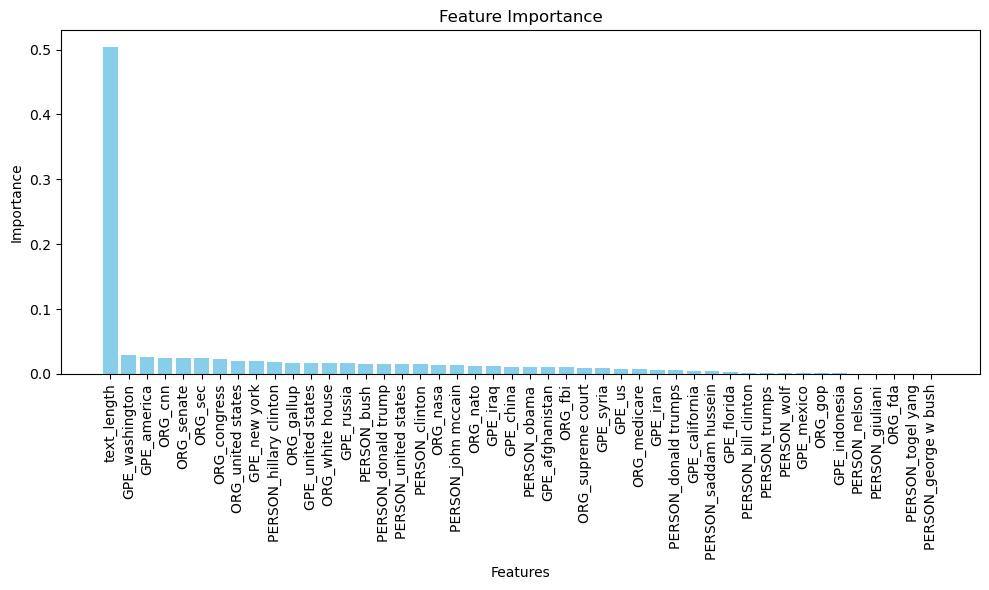

In [17]:
# binary classification


X_train, X_test, y_train, y_test = train_test_split(X, binary_Y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Display a classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Optionally, feature importance plot
importances = model.feature_importances_
indices = importances.argsort()[::-1]  # Sort feature importance in descending order

plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), importances[indices], align="center", color="skyblue")
plt.xticks(range(X_train.shape[1]), [X.columns[i] for i in indices], rotation=90)
plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()



Accuracy: 0.37

Classification Report:
              precision    recall  f1-score   support

           1       0.44      0.57      0.50        58
           2       0.15      0.09      0.11        22
           3       0.42      0.47      0.44        60
           4       0.00      0.00      0.00        11
           5       0.10      0.05      0.07        20

    accuracy                           0.37       171
   macro avg       0.22      0.24      0.22       171
weighted avg       0.33      0.37      0.35       171


Confusion Matrix:
[[33  4 17  0  4]
 [10  2  9  1  0]
 [19  5 28  4  4]
 [ 5  2  3  0  1]
 [ 8  0  9  2  1]]


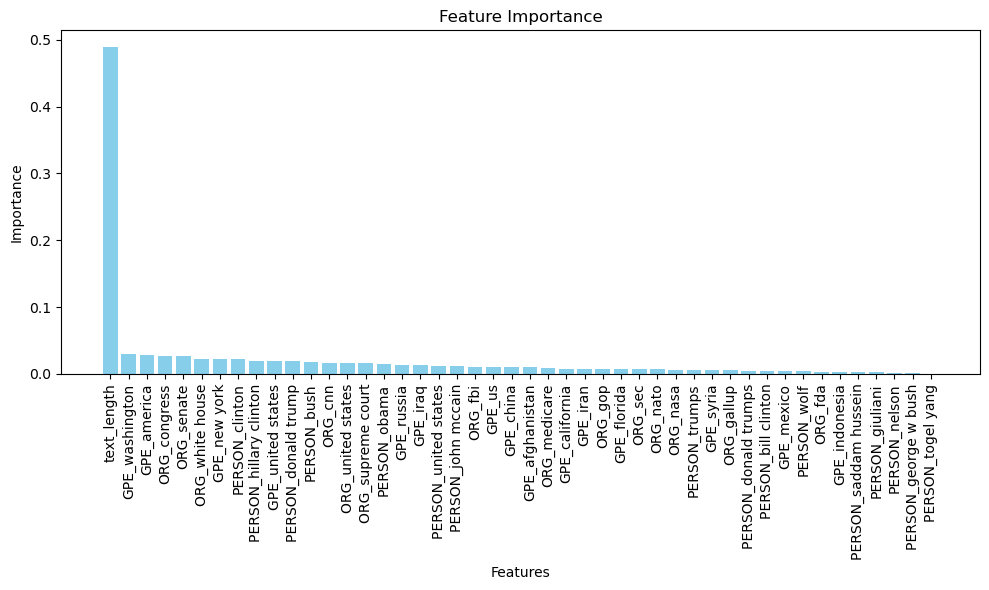

In [23]:
#classifier (5 classes)

X_train, X_test, y_train, y_test = train_test_split(X, multi_class_Y, test_size=0.2, random_state=42)

# Define Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate the Model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Feature Importance Plot
importances = model.feature_importances_
indices = importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), importances[indices], align="center", color="skyblue")
plt.xticks(range(X_train.shape[1]), [X.columns[i] for i in indices], rotation=90)
plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

Mean Squared Error (MSE): 5512935.28
R-squared (R2): -0.11


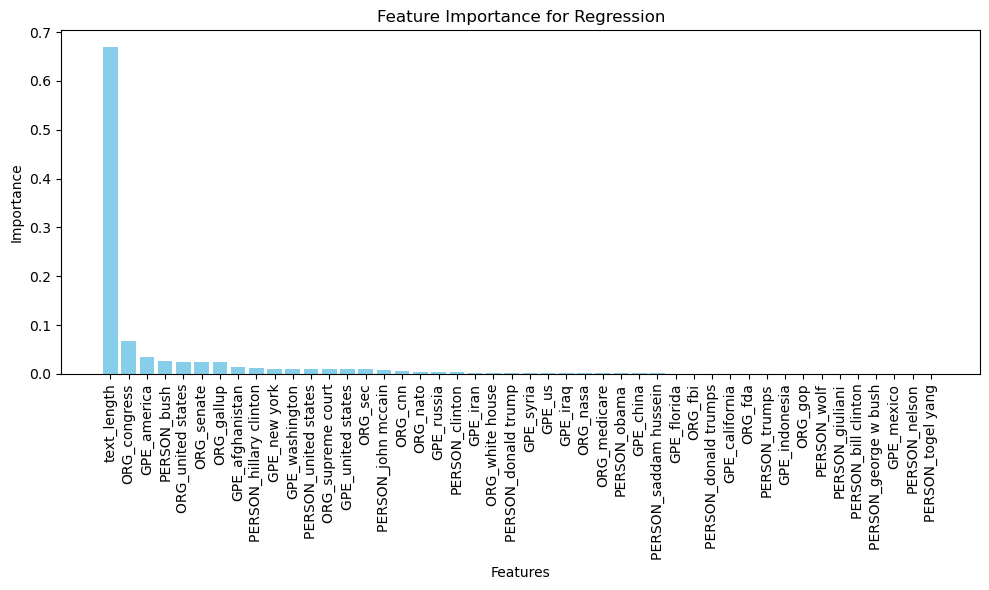

In [28]:

# regression model using random forest
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Define Regression Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate Model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

# Feature Importance Plot
importances = model.feature_importances_
indices = importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), importances[indices], align="center", color="skyblue")
plt.xticks(range(X_train.shape[1]), [X.columns[i] for i in indices], rotation=90)
plt.title("Feature Importance for Regression")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

In [30]:
# binary neural network

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, binary_Y, test_size=0.2, random_state=42)

# Define the Neural Network Model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the Model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the Model
y_pred = (model.predict(X_test) > 0.5).astype(int)  # Convert probabilities to binary output
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Classification Report and Confusion Matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


2025-01-07 19:11:44.343905: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-07 19:11:44.348161: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-07 19:11:44.394455: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-07 19:11:44.430220: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736257304.468254   60405 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736257304.48

Epoch 1/20


/home/kaushik/anaconda3/envs/obaiba/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-01-07 19:11:45.940723: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7914 - loss: 208.5836 - val_accuracy: 0.1287 - val_loss: 2.1890
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6748 - loss: 8.1932 - val_accuracy: 0.8713 - val_loss: 1.3660
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8141 - loss: 4.2405 - val_accuracy: 0.8772 - val_loss: 14.5294
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7472 - loss: 17.6915 - val_accuracy: 0.8772 - val_loss: 24.0898
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8348 - loss: 7.7021 - val_accuracy: 0.8772 - val_loss: 4.8292
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6980 - loss: 4.6125 - val_accuracy: 0.2164 - val_loss: 5.2573
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5662 - loss: 16.2041 - val_accuracy: 0.8772 - val_loss: 9.6416
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7933 - loss: 11.1650 - val_accuracy: 0.8772 - val_loss: 19.

/home/kaushik/anaconda3/envs/obaiba/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kaushik/anaconda3/envs/obaiba/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kaushik/anaconda3/envs/obaiba/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

In [34]:
# 5 class classifier by neural network

# Encode the target for multi-class classification
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(multi_class_Y)
y_categorical = to_categorical(y_encoded, num_classes=5)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Define the Neural Network Model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')  # Softmax for multi-class classification
])

# Compile the Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the Model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the Model
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)  # Get the predicted class
y_test_classes = y_test.argmax(axis=1)  # Get the true class

accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f'Accuracy: {accuracy:.2f}')

# Classification Report and Confusion Matrix
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_classes, y_pred_classes))


Epoch 1/20


/home/kaushik/anaconda3/envs/obaiba/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2639 - loss: 403.5840 - val_accuracy: 0.3392 - val_loss: 111.0281
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3583 - loss: 54.7062 - val_accuracy: 0.3392 - val_loss: 22.6187
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2588 - loss: 49.6405 - val_accuracy: 0.1754 - val_loss: 84.1102
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2335 - loss: 24.7109 - val_accuracy: 0.3918 - val_loss: 54.9409
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2868 - loss: 34.9154 - val_accuracy: 0.3918 - val_loss: 23.0294
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2476 - loss: 32.1974 - val_accuracy: 0.3450 - val_loss: 36.4717
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2694 - loss: 26.2641 - val_accuracy: 0.3450 - val_loss: 65.9887
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2735 - loss: 31.0302 - val_accuracy: 0.1345 - val

/home/kaushik/anaconda3/envs/obaiba/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kaushik/anaconda3/envs/obaiba/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kaushik/anaconda3/envs/obaiba/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

In [36]:

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Define the Neural Network Model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')  # Linear activation for regression
])

# Compile the Model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# Train the Model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the Model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

Epoch 1/20


/home/kaushik/anaconda3/envs/obaiba/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5368953.5000 - mse: 5368953.5000 - val_loss: 5392949.5000 - val_mse: 5392949.5000
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4799442.0000 - mse: 4799442.0000 - val_loss: 5185671.0000 - val_mse: 5185671.0000
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3124540.0000 - mse: 3124540.0000 - val_loss: 5171737.5000 - val_mse: 5171737.5000
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5046548.0000 - mse: 5046548.0000 - val_loss: 5408429.5000 - val_mse: 5408429.5000
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3837068.2500 - mse: 3837068.2500 - val_loss: 6154430.0000 - val_mse: 6154430.0000
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5561076.5000 - mse: 5561076.5000 - val_loss: 5668494.0000 - val_mse: 5668494.0000
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3760959.2500 - mse: 3760959.2500 - val_loss: 5177304.5000 - val_mse: 5177304.5000
Epoch 8/20
22/22 ━━━━━━━━━━━━━━

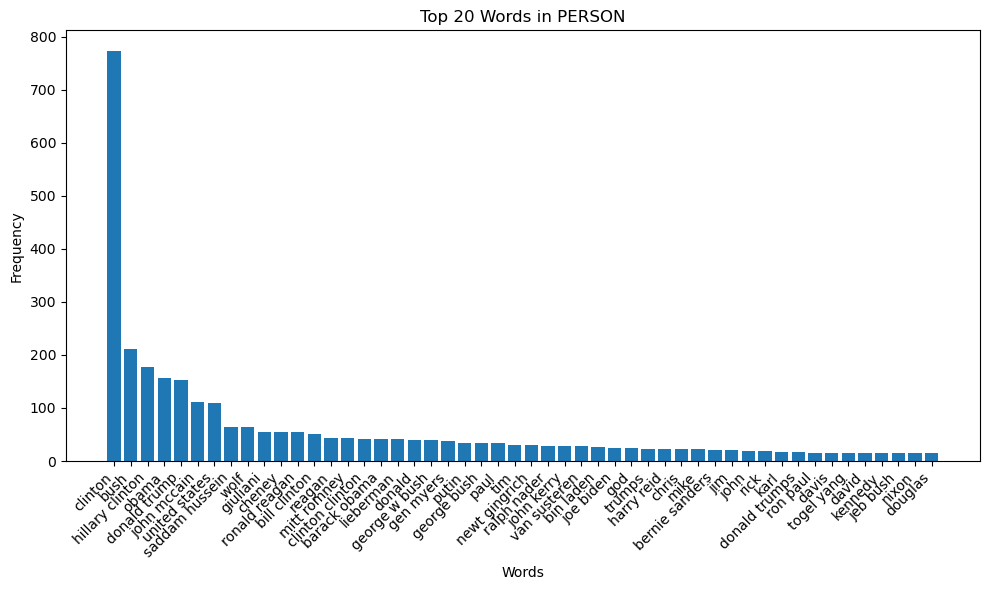

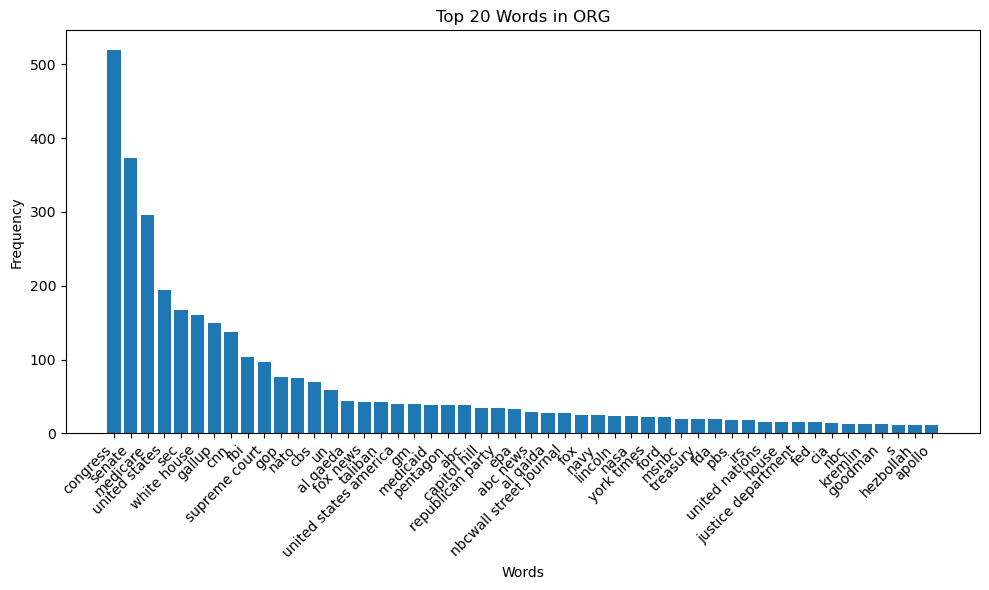

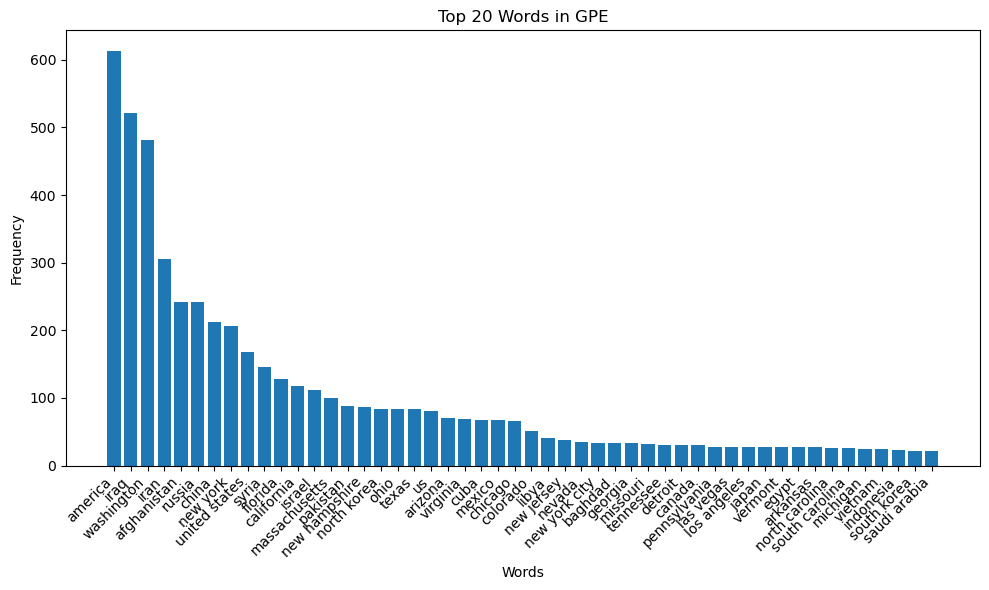

In [15]:
# PLOTS

# analyse the ner data
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# Assuming your DataFrame is named `df` and contains the columns `PERSON`, `ORG`, and `GPE`
df = merged_p
# Flatten the lists and count occurrences for each category
categories = ['PERSON', 'ORG', 'GPE']
word_counts = {}

for category in categories:
    # Combine all lists in the column into one flat list
    all_words = sum(df[category], [])  # Flatten the lists
    word_counts[category] = Counter(all_words)  # Count occurrences

# Plot histograms for each category
for category, counts in word_counts.items():
    # Convert Counter to DataFrame for plotting
    words, frequencies = zip(*counts.most_common(50))  # Get top 20 most common words
    plt.figure(figsize=(10, 6))
    plt.bar(words, frequencies)
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Top 20 Words in {category}")
    plt.ylabel("Frequency")
    plt.xlabel("Words")
    plt.tight_layout()
    plt.show()

